'subgrid_params': {
    'viscosity_scale': 1.0,
    # Physical meaning: Multiplies hyperviscosity coefficient
    # Effect: Higher = more damping of small scales
    # Range: [0.5, 5.0]
    # Typical tuned value: 1.5 - 2.5 for low-res
    # Physics: Must be > 0, unrealistic if > 10
    
    'drag_scale': 1.0,
    # Physical meaning: Multiplies Ekman drag coefficient  
    # Effect: Higher = faster energy dissipation in lower layer
    # Range: [0.5, 3.0]
    # Typical tuned value: 1.2 - 2.0 for low-res
    # Physics: Must be > 0, unrealistic if > 5
    
    'eddy_diffusivity': 0.0,
    # Physical meaning: Additional biharmonic diffusion (m²/s)
    # Effect: Smooths gradients, represents unresolved mixing
    # Range: [0.0, 1e5]
    # Typical tuned value: 1e4 - 5e4 for low-res
    # Physics: Must be ≥ 0, rarely > 1e6
    
    'smagorinsky_coeff': 0.0,
    # Physical meaning: Smagorinsky eddy viscosity coefficient
    # Effect: Dynamic viscosity proportional to strain rate
    # Range: [0.0, 0.3]
    # Typical tuned value: 0.10 - 0.20
    # Physics: Must be ≥ 0, standard value ~0.15, rarely > 0.5
    
    'energy_correction': 0.0,
    # Physical meaning: Energy tendency correction (backscatter)
    # Effect: Negative = adds energy (inverse cascade)
    #         Positive = removes energy
    # Range: [-0.01, 0.01]
    # Typical tuned value: -0.002 to -0.008 (backscatter)
    # Physics: |value| > 0.02 often causes instability
    
    'enstrophy_correction': 0.0,
    # Physical meaning: Additional enstrophy dissipation rate
    # Effect: Removes small-scale vorticity fluctuations
    # Range: [0.0, 1e-6]
    # Typical tuned value: 1e-7 - 5e-7
    # Physics: Must be ≥ 0, > 1e-5 causes over-damping
}


QG TWO-LAYER MODEL: HIGH-RES vs LOW-RES COMPARISON

LOADING EXISTING HIGH-RES RESULTS
✓ High-res results loaded successfully
  Grid: 512 x 256
  Time range: 0 to 180.0 days
  Snapshots: 361

LOADING EXISTING LOW-RES RESULTS
✓ Low-res results loaded successfully
  Grid: 64 x 32
  Time range: 0 to 180.0 days
  Snapshots: 361
  ✓ Subgrid parameters match

GENERATING COMPARISON PLOTS

Comparison plot saved to comparison_statistics.png


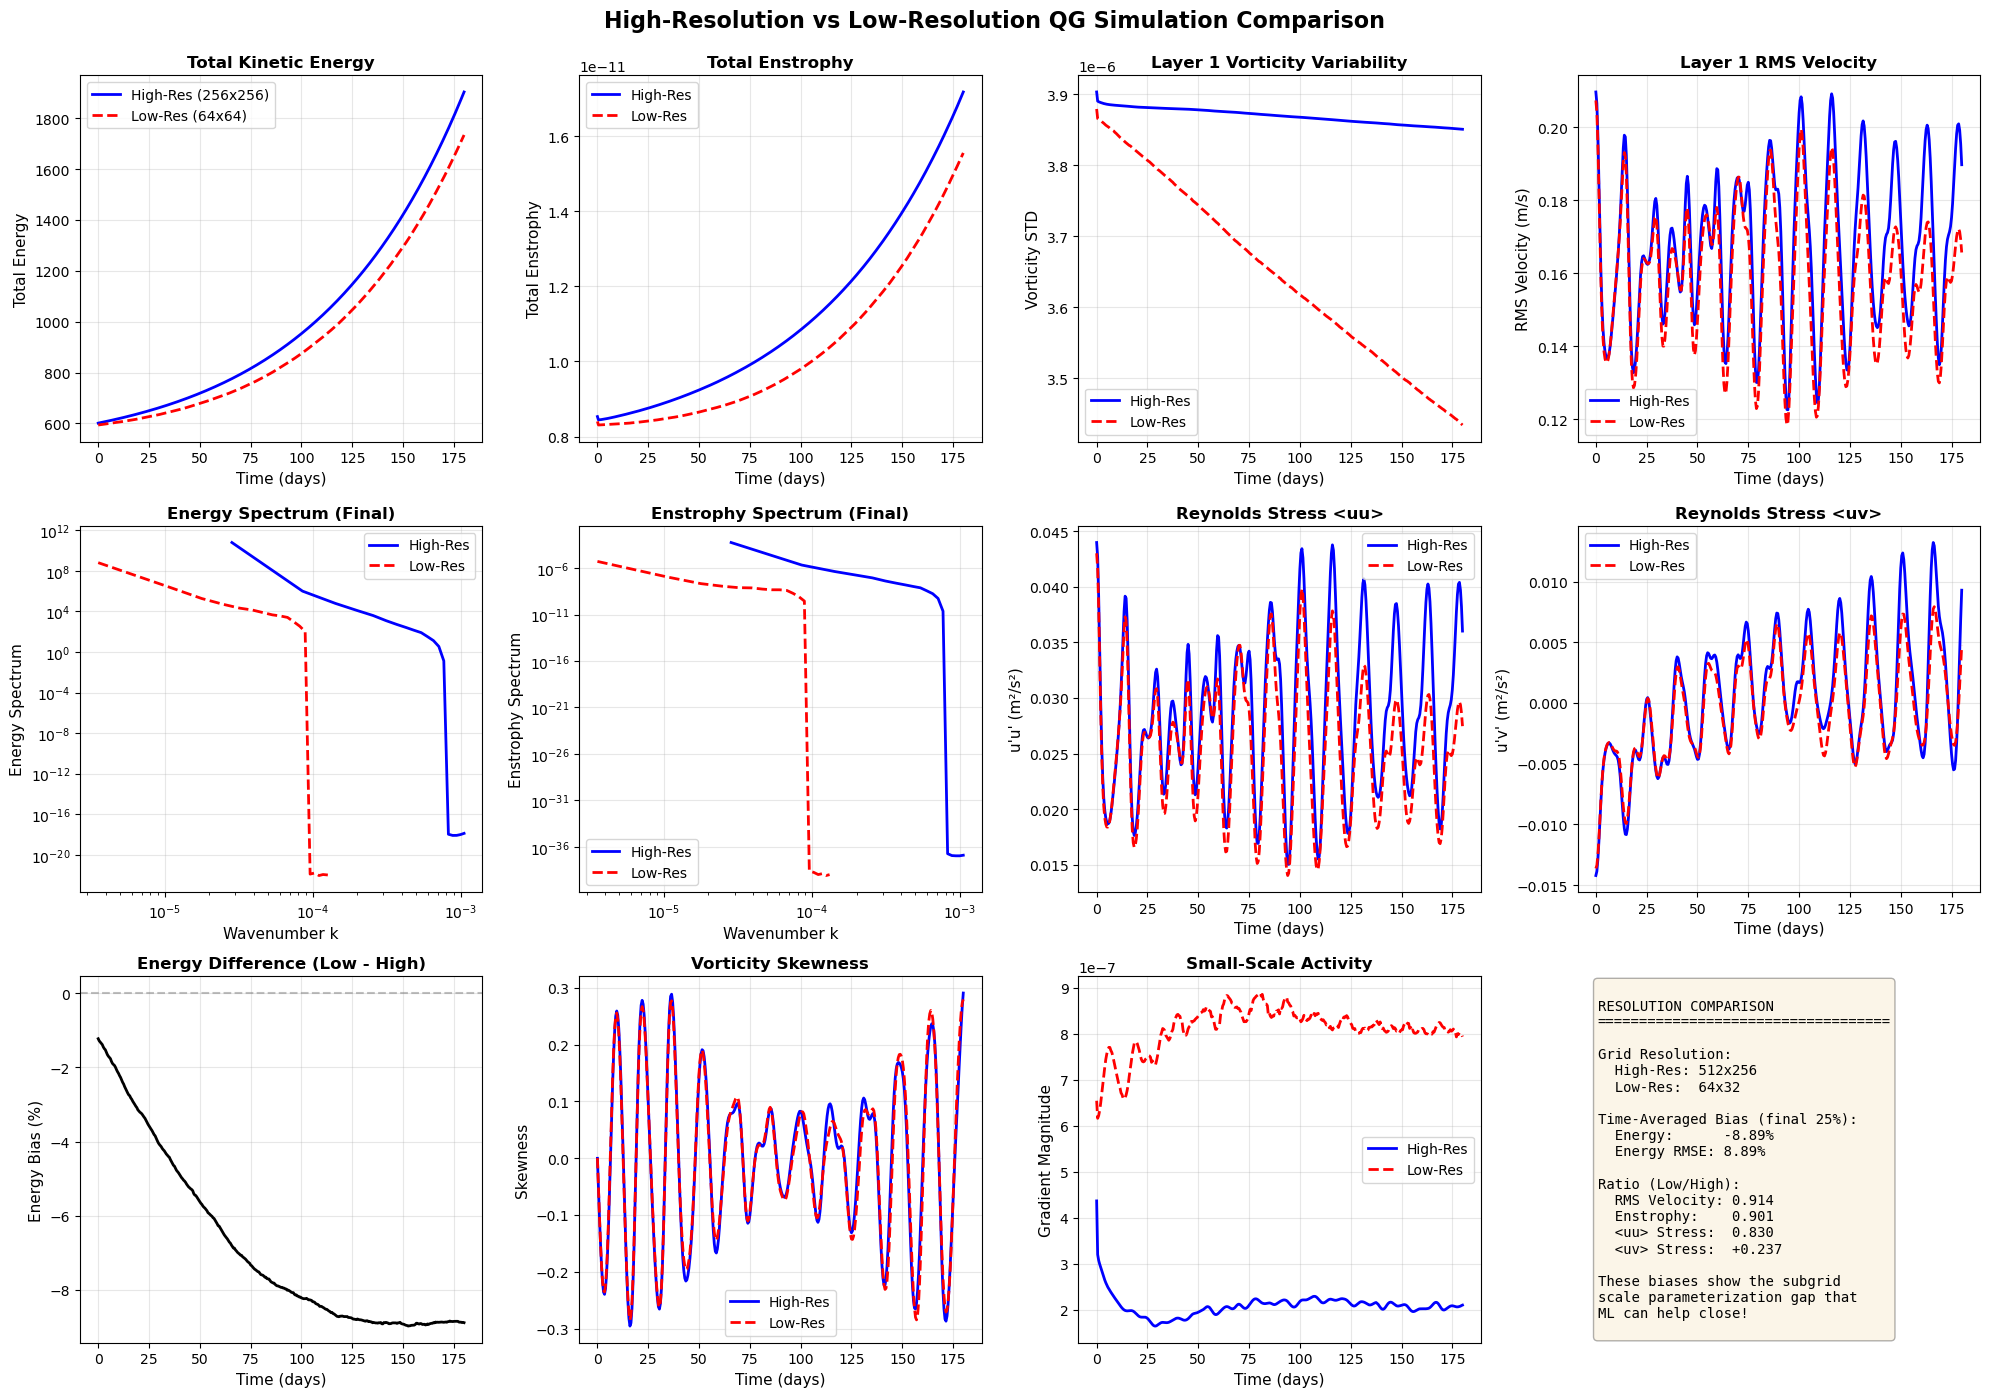


DETAILED COMPARISON SUMMARY

GRID INFORMATION:
  High-Res: 512x256 (dx = 3.9 km)
  Low-Res:  64x32 (dx = 31.2 km)
  Resolution Ratio: 8x coarser

KEY STATISTICS (Time-Averaged, Final 25%):
  Energy Bias:        -8.89%
  Energy RMSE:        8.89%
  Velocity Ratio:     0.914
  Enstrophy Ratio:    0.901
  Reynolds uu Ratio:  0.830

FIELD DIFFERENCES (Final Time, Low-Res vs Coarsened High-Res):
  Vorticity Layer 1 NRMSE:      0.243
  Vorticity Layer 2 NRMSE:      0.417
  Streamfunction Layer 1 NRMSE: 0.117
  Streamfunction Layer 2 NRMSE: 0.074

  Note: NRMSE = Normalized RMS Error (difference / std_deviation)
        Values > 0.3 indicate significant bias needing parameterization


TIME-AVERAGED COMPARISON (Last 30 days)

COMPUTING TIME-AVERAGED FIELDS (Last 30 days)
Averaging over last 30 days (61 snapshots)
Time range: 150.0 to 180.0 days
Averaging over last 30 days (61 snapshots)
Time range: 150.0 to 180.0 days

TIME-AVERAGED FIELD COMPARISON

Vorticity NRMSE:
  Layer 1:    0.3011
  La

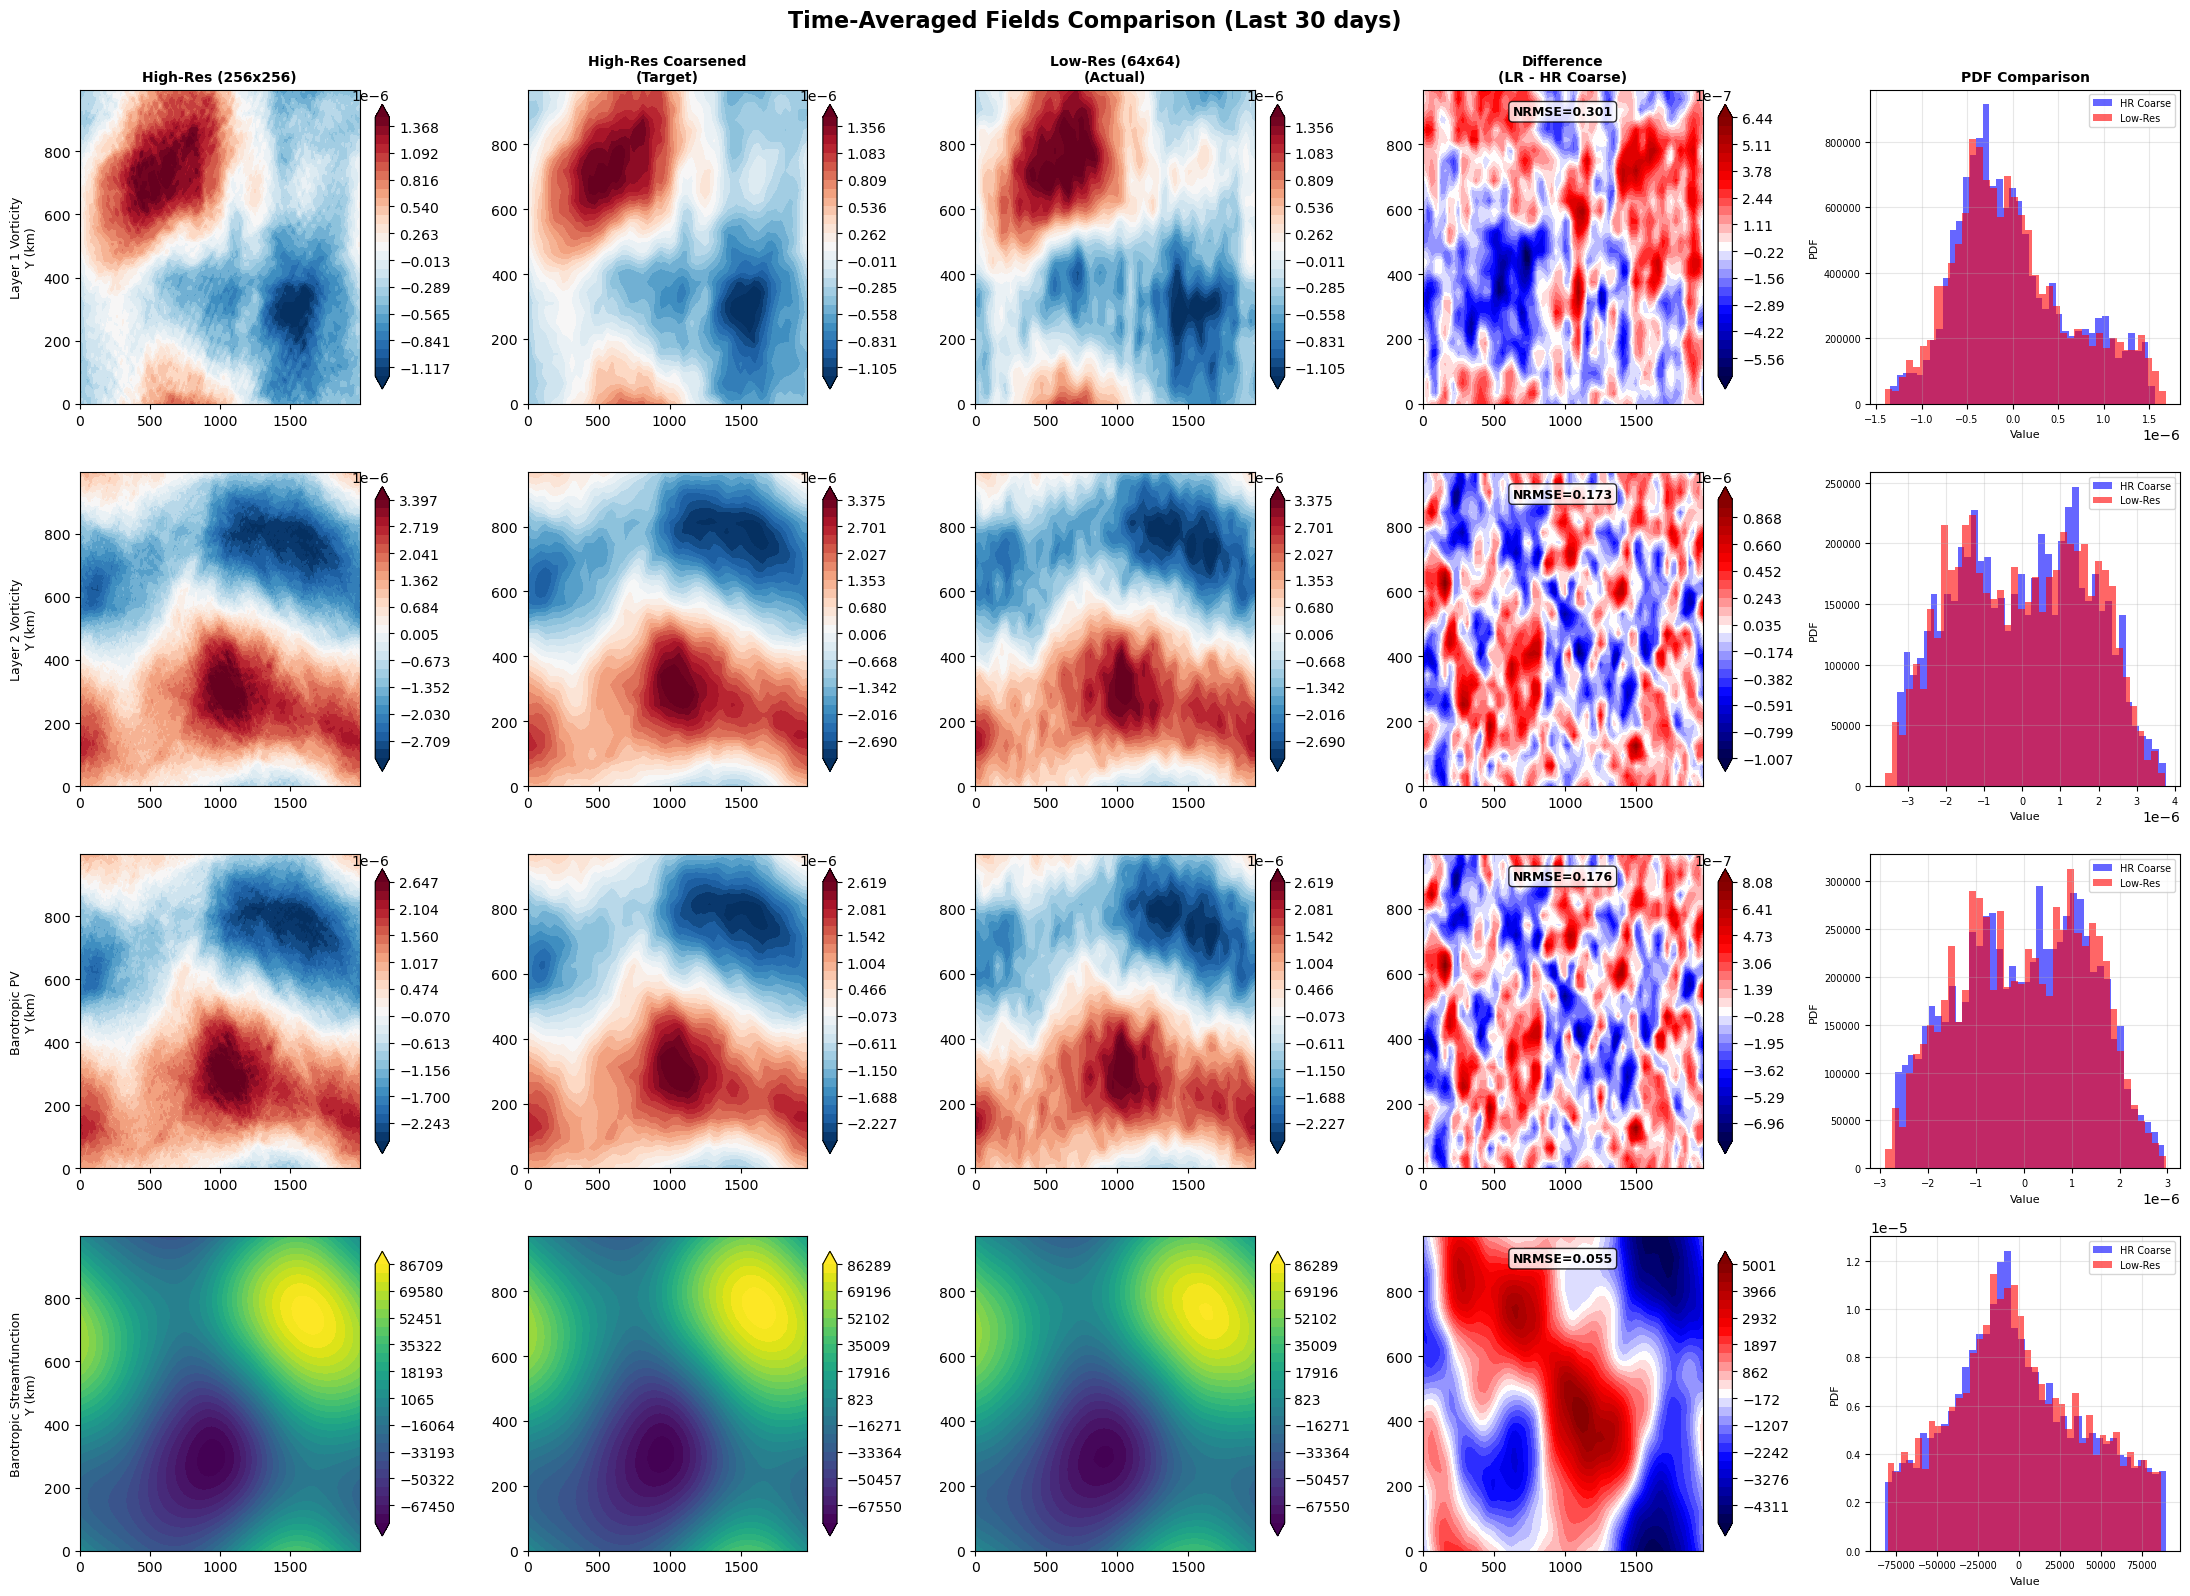


COMPLETE!
Generated files:
  - comparison_statistics.png
  - field_comparison.png
  - time_averaged_comparison.png
  - comparison_metrics.pkl


In [1]:
"""
Main Script for High-Res vs Low-Res QG Comparison
Run both simulations and compare results
"""

import numpy as np
import pickle
import os
from qg_model import QGTwoLayerModel
from qg_comparison import (compute_spectral_stats, compute_spatial_stats, 
                            compute_eddy_fluxes, plot_comparison, 
                            print_comparison_summary, compute_field_differences, 
                            plot_field_comparison)
from qg_advanced_analysis import compare_time_averaged_fields, plot_time_averaged_comparison

# ============================================================================
# CONFIGURATION: HIGH RESOLUTION (Ground Truth)
# ============================================================================

config_highres = {
    'name': 'HighRes_512x256',
    'nx': 512,
    'ny': 256,
    'Lx': 2.0e6,                  # 2000 km domain
    'Ly': 1.0e6,                  # 1000 km
    
    'beta': 1.8e-11,              # Moderate beta
    'f0': 1e-4,
    'g_prime': 0.02,              # Standard stratification
    'H1': 750.0,                  # Intermediate layer depth
    'H2': 3250.0,
    
    'r_drag': 8e-8,               # Moderate drag
    'nu': 3e14,                   # Moderate viscosity
    
    'dt': 600.0,                  # 10 min
}

# ============================================================================
# CONFIGURATION: LOW RESOLUTION (With Subgrid Parameters to Tune)
# ============================================================================

config_lowres = {
    'name': 'LowRes_64x32',
    'nx': 64,
    'ny': 32,
    'Lx': 2.0e6,                  # SAME as high-res
    'Ly': 1.0e6,                  # SAME as high-res
    
    'beta': 1.8e-11,              # SAME
    'f0': 1e-4,
    'g_prime': 0.02,              # SAME
    'H1': 750.0,                  # SAME
    'H2': 3250.0,
    
    'r_drag': 8e-8,               # SAME - will be insufficient at low-res
    'nu': 3e14,                   # SAME - will be insufficient at low-res
    

    'dt': 1800.0,                 # 30 min

  # new default
   #  'subgrid_params': {
   #      'viscosity_scale': .5,
   #      'drag_scale': .5,
   #      'eddy_diffusivity': .005,
   #      'smagorinsky_coeff': .015,
   #      'energy_correction': -0.002,
   #      'enstrophy_correction': 3e-9,
   # }
    
    
#GF tuning
    # 'subgrid_params': {
    #     'viscosity_scale': 5.000000e-01,
    #     'drag_scale': 5.000000e-01,
    #     'eddy_diffusivity': 5.000000e-03,
    #     'smagorinsky_coeff': 1.500000e-02,
    #     'energy_correction': -1.999990e-03,
    #     'enstrophy_correction': 3.600000e-09,
    # }

# optimal parameters:
    'subgrid_params': {
        'viscosity_scale': 2.601599e+00,
        'drag_scale': 1.077783e+00,
        'eddy_diffusivity': 4.651542e+04,
        'smagorinsky_coeff': 1.692916e-01,
        'energy_correction': -1.029489e-04,
        'enstrophy_correction': 7.289915e-09,
   }


    #defualt best value
    # 'subgrid_params': {
    #     'viscosity_scale': 1.0,
    #     'drag_scale': 1.0,
    #     'eddy_diffusivity': 0.0,
    #     'smagorinsky_coeff': 0.0,
    #     'energy_correction': 0.0,
    #     'enstrophy_correction': 0.0,
    # }
}

# ============================================================================
# INITIAL CONDITIONS
# ============================================================================

def create_initial_conditions(nx, ny, Lx, Ly):
    """Create initial vortices with multi-scale structure"""
    x = np.arange(nx) * (Lx / nx)
    y = np.arange(ny) * (Ly / ny)
    X, Y = np.meshgrid(x, y)
    
    # Moderate number of vortices with moderate amplitudes
    vortex_params = [
        # Large-scale vortices
        {'x': 0.2*Lx, 'y': 0.3*Ly, 'sigma': 0.13*Lx, 'amp1': 4e-6, 'amp2': 2.5e-6},
        {'x': 0.8*Lx, 'y': 0.7*Ly, 'sigma': 0.13*Lx, 'amp1': -4e-6, 'amp2': -2.5e-6},
        {'x': 0.2*Lx, 'y': 0.7*Ly, 'sigma': 0.12*Lx, 'amp1': 3.5e-6, 'amp2': -2e-6},
        {'x': 0.8*Lx, 'y': 0.3*Ly, 'sigma': 0.12*Lx, 'amp1': -3.5e-6, 'amp2': 2e-6},
        
        # Medium-scale vortices
        {'x': 0.35*Lx, 'y': 0.5*Ly, 'sigma': 0.09*Lx, 'amp1': 3e-6, 'amp2': 1.5e-6},
        {'x': 0.65*Lx, 'y': 0.5*Ly, 'sigma': 0.09*Lx, 'amp1': -3e-6, 'amp2': -1.5e-6},
        {'x': 0.5*Lx, 'y': 0.25*Ly, 'sigma': 0.08*Lx, 'amp1': 2.5e-6, 'amp2': 0.0},
        {'x': 0.5*Lx, 'y': 0.75*Ly, 'sigma': 0.08*Lx, 'amp1': -2.5e-6, 'amp2': 0.0},
        
        # Small-scale vortices (poorly resolved at low-res)
        {'x': 0.4*Lx, 'y': 0.35*Ly, 'sigma': 0.06*Lx, 'amp1': 2e-6, 'amp2': 1e-6},
        {'x': 0.6*Lx, 'y': 0.65*Ly, 'sigma': 0.06*Lx, 'amp1': -2e-6, 'amp2': -1e-6},
        {'x': 0.3*Lx, 'y': 0.6*Ly, 'sigma': 0.05*Lx, 'amp1': 1.5e-6, 'amp2': 0.8e-6},
        {'x': 0.7*Lx, 'y': 0.4*Ly, 'sigma': 0.05*Lx, 'amp1': -1.5e-6, 'amp2': -0.8e-6},
    ]
    
    q1 = np.zeros((ny, nx))
    q2 = np.zeros((ny, nx))
    
    for vortex in vortex_params:
        x0, y0 = vortex['x'], vortex['y']
        sigma = vortex['sigma']
        amp1, amp2 = vortex['amp1'], vortex['amp2']
        
        r2 = (X - x0)**2 + (Y - y0)**2
        gauss = np.exp(-r2 / (2 * sigma**2))
        
        q1 += amp1 * gauss
        q2 += amp2 * gauss
    
    # Add modest multi-scale noise
    np.random.seed(42)
    
    # Only 2 scales of noise for stability
    for i in range(2):
        scale = 2**i
        if nx // scale >= 8:
            noise_q1 = np.random.randn(ny // scale, nx // scale)
            noise_q2 = np.random.randn(ny // scale, nx // scale)
            
            if scale > 1:
                from scipy.ndimage import zoom
                noise_q1 = zoom(noise_q1, scale, order=1)
                noise_q2 = zoom(noise_q2, scale, order=1)
            
            amplitude = 8e-7 / (scale + 1)  # Reduced amplitude
            q1 += amplitude * noise_q1
            q2 += amplitude * noise_q2
    
    return q1, q2

# ============================================================================
# RUN SIMULATION
# ============================================================================

def run_simulation(config, sim_days=180, save_interval_hours=12):
    """Run simulation and collect statistics"""
    
    print("\n" + "="*70)
    print(f"Running {config['name']} Simulation")
    print("="*70)
    print(f"Grid: {config['nx']} x {config['ny']}")
    print(f"Resolution: {config['Lx']/config['nx']/1e3:.1f} km per grid point")
    
    if 'subgrid_params' in config:
        print("\nSubgrid Parameters:")
        for key, val in config['subgrid_params'].items():
            print(f"  {key}: {val}")
    
    model = QGTwoLayerModel(config)
    q1, q2 = create_initial_conditions(config['nx'], config['ny'], 
                                       config['Lx'], config['Ly'])
    
    steps_per_day = int(86400 / config['dt'])
    total_steps = sim_days * steps_per_day
    save_every = int(save_interval_hours * 3600 / config['dt'])
    
    q1_history = [q1.copy()]
    q2_history = [q2.copy()]
    times = [0.0]
    
    energy_history = {'total': [], 'layer1': [], 'layer2': []}
    enstrophy_history = {'layer1': [], 'layer2': []}
    spatial_stats_history = []
    spectral_stats_history = []
    eddy_flux_history = []
    
    KE1, KE2, KE = model.compute_energy(q1, q2)
    ens1, ens2 = model.compute_enstrophy(q1, q2)
    
    energy_history['total'].append(KE)
    energy_history['layer1'].append(KE1)
    energy_history['layer2'].append(KE2)
    enstrophy_history['layer1'].append(ens1)
    enstrophy_history['layer2'].append(ens2)
    
    spatial_stats = compute_spatial_stats(model, q1, q2)
    spatial_stats_history.append(spatial_stats)
    
    k, KE_spec, Z_spec = compute_spectral_stats(model, q1, q2)
    spectral_stats_history.append({'k': k, 'KE': KE_spec, 'Z': Z_spec})
    
    fluxes = compute_eddy_fluxes(model, q1, q2)
    eddy_flux_history.append(fluxes)
    
    print(f"\nInitial Energy: {KE:.3e}")
    print(f"Initial Enstrophy: {ens1+ens2:.3e}")
    print("\nIntegrating...")
    
    dq1_hist = []
    dq2_hist = []
    
    for step in range(1, total_steps + 1):
        q1, q2 = model.step_ab3(q1, q2, dq1_hist, dq2_hist)
        
        if not (np.isfinite(q1).all() and np.isfinite(q2).all()):
            print(f"\n*** Unstable at step {step} ***")
            break
        
        if step % save_every == 0:
            t = step * config['dt'] / 86400
            times.append(t)
            q1_history.append(q1.copy())
            q2_history.append(q2.copy())
            
            KE1, KE2, KE = model.compute_energy(q1, q2)
            ens1, ens2 = model.compute_enstrophy(q1, q2)
            
            energy_history['total'].append(KE)
            energy_history['layer1'].append(KE1)
            energy_history['layer2'].append(KE2)
            enstrophy_history['layer1'].append(ens1)
            enstrophy_history['layer2'].append(ens2)
            
            spatial_stats = compute_spatial_stats(model, q1, q2)
            spatial_stats_history.append(spatial_stats)
            
            k, KE_spec, Z_spec = compute_spectral_stats(model, q1, q2)
            spectral_stats_history.append({'k': k, 'KE': KE_spec, 'Z': Z_spec})
            
            fluxes = compute_eddy_fluxes(model, q1, q2)
            eddy_flux_history.append(fluxes)
            
            if step % (save_every * 4) == 0:
                print(f"  Day {t:5.1f} | Energy: {KE:.3e} | Enstrophy: {ens1+ens2:.3e}")
    
    print("\n" + "="*70)
    print(f"{config['name']} Simulation Complete!")
    print("="*70)
    
    results = {
        'config': config,
        'model': model,
        'times': np.array(times),
        'q1_history': q1_history,
        'q2_history': q2_history,
        'energy_history': energy_history,
        'enstrophy_history': enstrophy_history,
        'spatial_stats_history': spatial_stats_history,
        'spectral_stats_history': spectral_stats_history,
        'eddy_flux_history': eddy_flux_history,
    }
    
    return results

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Run both simulations and compare"""
    
    print("\n" + "="*70)
    print("QG TWO-LAYER MODEL: HIGH-RES vs LOW-RES COMPARISON")
    print("="*70)
    
    # Check for existing high-res results
    if os.path.exists('highres_results.pkl'):
        print("\n" + "="*70)
        print("LOADING EXISTING HIGH-RES RESULTS")
        print("="*70)
        try:
            with open('highres_results.pkl', 'rb') as f:
                highres_results = pickle.load(f)
            print("✓ High-res results loaded successfully")
            print(f"  Grid: {highres_results['config']['nx']} x {highres_results['config']['ny']}")
            print(f"  Time range: 0 to {highres_results['times'][-1]:.1f} days")
            print(f"  Snapshots: {len(highres_results['times'])}")
        except Exception as e:
            print(f"✗ Error loading: {e}")
            print("  Running new simulation...")
            highres_results = run_simulation(config_highres, save_interval_hours=12)
            with open('highres_results.pkl', 'wb') as f:
                pickle.dump(highres_results, f)
            print("\n✓ High-res results saved")
    else:
        print("\n✗ No high-res results found. Running simulation...")
        highres_results = run_simulation(config_highres,  save_interval_hours=12)
        with open('highres_results.pkl', 'wb') as f:
            pickle.dump(highres_results, f)
        print("\n✓ High-res results saved")
    
    # Check for existing low-res results
    if os.path.exists('lowres_results.pkl'):
        print("\n" + "="*70)
        print("LOADING EXISTING LOW-RES RESULTS")
        print("="*70)
        try:
            with open('lowres_results.pkl', 'rb') as f:
                lowres_results = pickle.load(f)
            print("✓ Low-res results loaded successfully")
            print(f"  Grid: {lowres_results['config']['nx']} x {lowres_results['config']['ny']}")
            print(f"  Time range: 0 to {lowres_results['times'][-1]:.1f} days")
            print(f"  Snapshots: {len(lowres_results['times'])}")
            
            # Check subgrid params
            if 'subgrid_params' in lowres_results['config']:
                loaded = lowres_results['config']['subgrid_params']
                current = config_lowres['subgrid_params']
                
                match = all(loaded.get(k) == v for k, v in current.items())
                
                if not match:
                    print("\n⚠️  Subgrid parameters differ!")
                    print("  Loaded:")
                    for k, v in loaded.items():
                        marker = " ←DIFF" if loaded[k] != current.get(k) else ""
                        print(f"    {k}: {v}{marker}")
                    
                    resp = input("\n  Re-run with current params? (y/n): ")
                    if resp.lower() == 'y':
                        lowres_results = run_simulation(config_lowres, sim_days=180, save_interval_hours=12)
                        with open('lowres_results.pkl', 'wb') as f:
                            pickle.dump(lowres_results, f)
                        print("\n✓ Low-res results saved")
                else:
                    print("  ✓ Subgrid parameters match")
        except Exception as e:
            print(f"✗ Error loading: {e}")
            print("  Running new simulation...")
            lowres_results = run_simulation(config_lowres,  save_interval_hours=12)
            with open('lowres_results.pkl', 'wb') as f:
                pickle.dump(lowres_results, f)
            print("\n✓ Low-res results saved")
    else:
        print("\n✗ No low-res results found. Running simulation...")
        lowres_results = run_simulation(config_lowres, save_interval_hours=12)
        with open('lowres_results.pkl', 'wb') as f:
            pickle.dump(lowres_results, f)
        print("\n✓ Low-res results saved")
    
    # Generate comparisons
    print("\n" + "="*70)
    print("GENERATING COMPARISON PLOTS")
    print("="*70)
    
    metrics = plot_comparison(highres_results, lowres_results, 'comparison_statistics.png')
    
    field_stats = compute_field_differences(highres_results, lowres_results)
    metrics['q1_nrmse'] = field_stats['q1_nrmse']
    metrics['q2_nrmse'] = field_stats['q2_nrmse']
    metrics['psi1_nrmse'] = field_stats['psi1_nrmse']
    metrics['psi2_nrmse'] = field_stats['psi2_nrmse']
    
    #plot_field_comparison(highres_results, lowres_results, field_stats, 'field_comparison.png')
    
    print_comparison_summary(highres_results, lowres_results, metrics)
    
    # Time-averaged comparison (last 30 days)
    print("\n" + "="*70)
    print("TIME-AVERAGED COMPARISON (Last 30 days)")
    print("="*70)
    comparison = compare_time_averaged_fields(highres_results, lowres_results, n_days=30)
    plot_time_averaged_comparison(comparison, highres_results, lowres_results,
                                  output_file='time_averaged_comparison.png')
    
    with open('comparison_metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)
    
    print("\n" + "="*70)
    print("COMPLETE!")
    print("="*70)
    print("Generated files:")
    print("  - comparison_statistics.png")
    print("  - field_comparison.png")
    print("  - time_averaged_comparison.png")
    print("  - comparison_metrics.pkl")
    print("="*70)
    
    return highres_results, lowres_results, metrics

if __name__ == "__main__":
    results = main()

In [11]:
"""
Animate High-Resolution QG Model Results (Days 0-30)

Loads highres_results.pkl and creates animations at 30 fps
Options to visualize:
- Potential vorticity (q1, q2, barotropic)
- Streamfunction (psi1, psi2, barotropic)
- Both layers side-by-side
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
import os

class QGAnimator:
    """Create animations from QG model results"""
    
    def __init__(self, results_file='highres_results.pkl'):
        """Load results from pickle file"""
        print(f"Loading data from {results_file}...")
        with open(results_file, 'rb') as f:
            self.results = pickle.load(f)
        
        self.times = np.array(self.results['times'])
        self.q1_history = self.results['q1_history']
        self.q2_history = self.results['q2_history']
        self.model = self.results['model']
        self.config = self.results['config']
        
        print(f"✓ Loaded {len(self.times)} time steps")
        print(f"  Resolution: {self.config['nx']}x{self.config['ny']}")
        print(f"  Time range: {self.times[0]:.1f} - {self.times[-1]:.1f} days")
    
    def get_time_indices(self, t_start=0, t_end=30):
        """Get indices for time window"""
        mask = (self.times >= t_start) & (self.times <= t_end)
        indices = np.where(mask)[0]
        print(f"\n✓ Selected {len(indices)} frames from day {t_start} to {t_end}")
        print(f"  Frame interval: {np.mean(np.diff(self.times[indices])):.3f} days")
        return indices
    
    def compute_streamfunction(self, q1, q2):
        """Compute streamfunction from PV"""
        return self.model.q_to_psi(q1, q2)
    
    def compute_barotropic(self, field1, field2):
        """Compute barotropic (depth-averaged) field"""
        H1, H2 = self.model.H1, self.model.H2
        return (H1 * field1 + H2 * field2) / (H1 + H2)
    
    def animate_single_field(self, field='pv_barotropic', t_start=0, t_end=30, 
                            fps=30, output_file='highres_animation.mp4'):
        """
        Animate a single field
        
        Args:
            field: 'pv1', 'pv2', 'pv_barotropic', 'psi1', 'psi2', 'psi_barotropic'
            t_start, t_end: Time range in days
            fps: Frames per second
            output_file: Output video file
        """
        indices = self.get_time_indices(t_start, t_end)
        
        print(f"\nPreparing animation: {field}")
        print(f"  FPS: {fps}")
        print(f"  Duration: {len(indices)/fps:.1f} seconds")
        
        # Setup figure
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Get data for first frame to set up plot
        q1_0 = self.q1_history[indices[0]]
        q2_0 = self.q2_history[indices[0]]
        
        if field == 'pv1':
            data_0 = q1_0
            title_base = 'Layer 1 Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'pv2':
            data_0 = q2_0
            title_base = 'Layer 2 Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'pv_barotropic':
            data_0 = self.compute_barotropic(q1_0, q2_0)
            title_base = 'Barotropic Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'psi1':
            psi1_0, _ = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi1_0
            title_base = 'Layer 1 Streamfunction'
            cmap = 'RdBu_r'
        elif field == 'psi2':
            _, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi2_0
            title_base = 'Layer 2 Streamfunction'
            cmap = 'RdBu_r'
        elif field == 'psi_barotropic':
            psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = self.compute_barotropic(psi1_0, psi2_0)
            title_base = 'Barotropic Streamfunction'
            cmap = 'RdBu_r'
        else:
            raise ValueError(f"Unknown field: {field}")
        
        # Set color limits based on all data (for consistent scaling)
        print("  Computing color limits from all frames...")
        all_data = []
        for idx in indices[::max(1, len(indices)//20)]:  # Sample 20 frames
            q1, q2 = self.q1_history[idx], self.q2_history[idx]
            if 'psi' in field:
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                if field == 'psi1':
                    all_data.append(psi1)
                elif field == 'psi2':
                    all_data.append(psi2)
                elif field == 'psi_barotropic':
                    all_data.append(self.compute_barotropic(psi1, psi2))
            elif field == 'pv1':
                all_data.append(q1)
            elif field == 'pv2':
                all_data.append(q2)
            elif field == 'pv_barotropic':
                all_data.append(self.compute_barotropic(q1, q2))
        
        vmin = np.percentile(np.concatenate([d.flatten() for d in all_data]), 1)
        vmax = np.percentile(np.concatenate([d.flatten() for d in all_data]), 99)
        
        # For diverging colormaps, make symmetric
        if 'RdBu' in cmap:
            vmax = max(abs(vmin), abs(vmax))
            vmin = -vmax
        
        print(f"  Color range: [{vmin:.4e}, {vmax:.4e}]")
        
        # Create initial plot
        im = ax.contourf(data_0, levels=50, cmap=cmap, vmin=vmin, vmax=vmax, 
                        extend='both', origin='lower')
        ax.set_aspect('equal')
        ax.axis('off')
        
        title = ax.text(0.5, 1.02, '', transform=ax.transAxes, 
                       ha='center', fontsize=14, fontweight='bold')
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(title_base, fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        
        # Animation function
        def update(frame):
            idx = indices[frame]
            t = self.times[idx]
            
            q1 = self.q1_history[idx]
            q2 = self.q2_history[idx]
            
            if field == 'pv1':
                data = q1
            elif field == 'pv2':
                data = q2
            elif field == 'pv_barotropic':
                data = self.compute_barotropic(q1, q2)
            elif field == 'psi1':
                psi1, _ = self.compute_streamfunction(q1, q2)
                data = psi1
            elif field == 'psi2':
                _, psi2 = self.compute_streamfunction(q1, q2)
                data = psi2
            elif field == 'psi_barotropic':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                data = self.compute_barotropic(psi1, psi2)
            
            # Clear and redraw
            ax.clear()
            im = ax.contourf(data, levels=50, cmap=cmap, vmin=vmin, vmax=vmax,
                           extend='both', origin='lower')
            ax.set_aspect('equal')
            ax.axis('off')
            
            title.set_text(f'{title_base}\nDay {t:.2f}')
            
            if frame % 30 == 0:  # Progress every second
                print(f"  Frame {frame+1}/{len(indices)} (Day {t:.1f})")
            
            return [im, title]
        
        # Create animation
        print("\n🎬 Creating animation...")
        anim = animation.FuncAnimation(fig, update, frames=len(indices),
                                      interval=1000/fps, blit=False, repeat=False)
        
        # Save
        print(f"\n💾 Saving to {output_file}...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, bitrate=5000, codec='libx264')
        anim.save(output_file, writer=writer, dpi=150)
        
        plt.close()
        print(f"✓ Animation saved successfully!")
        print(f"  File: {output_file}")
        print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")
    
    def animate_two_layers(self, field='pv', t_start=0, t_end=30, 
                           fps=30, output_file='highres_two_layers.mp4'):
        """
        Animate both layers side-by-side
        
        Args:
            field: 'pv' or 'psi'
            t_start, t_end: Time range in days
            fps: Frames per second
            output_file: Output video file
        """
        indices = self.get_time_indices(t_start, t_end)
        
        print(f"\nPreparing two-layer animation: {field}")
        print(f"  FPS: {fps}")
        print(f"  Duration: {len(indices)/fps:.1f} seconds")
        
        # Setup figure with two subplots
        fig = plt.figure(figsize=(18, 8))
        gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.15)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        
        # Get data for first frame
        q1_0 = self.q1_history[indices[0]]
        q2_0 = self.q2_history[indices[0]]
        
        if field == 'pv':
            data1_0, data2_0 = q1_0, q2_0
            title_base = 'Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'psi':
            psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data1_0, data2_0 = psi1_0, psi2_0
            title_base = 'Streamfunction'
            cmap = 'RdBu_r'
        else:
            raise ValueError(f"Unknown field: {field}")
        
        # Compute color limits
        print("  Computing color limits from all frames...")
        all_data1, all_data2 = [], []
        for idx in indices[::max(1, len(indices)//20)]:
            q1, q2 = self.q1_history[idx], self.q2_history[idx]
            if field == 'pv':
                all_data1.append(q1)
                all_data2.append(q2)
            elif field == 'psi':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                all_data1.append(psi1)
                all_data2.append(psi2)
        
        vmin1 = np.percentile(np.concatenate([d.flatten() for d in all_data1]), 1)
        vmax1 = np.percentile(np.concatenate([d.flatten() for d in all_data1]), 99)
        vmin2 = np.percentile(np.concatenate([d.flatten() for d in all_data2]), 1)
        vmax2 = np.percentile(np.concatenate([d.flatten() for d in all_data2]), 99)
        
        # Make symmetric for diverging colormaps
        if 'RdBu' in cmap:
            vmax1 = max(abs(vmin1), abs(vmax1))
            vmin1 = -vmax1
            vmax2 = max(abs(vmin2), abs(vmax2))
            vmin2 = -vmax2
        
        print(f"  Layer 1 range: [{vmin1:.4e}, {vmax1:.4e}]")
        print(f"  Layer 2 range: [{vmin2:.4e}, {vmax2:.4e}]")
        
        # Create initial plots
        im1 = ax1.contourf(data1_0, levels=50, cmap=cmap, vmin=vmin1, vmax=vmax1,
                          extend='both', origin='lower')
        im2 = ax2.contourf(data2_0, levels=50, cmap=cmap, vmin=vmin2, vmax=vmax2,
                          extend='both', origin='lower')
        
        ax1.set_aspect('equal')
        ax2.set_aspect('equal')
        ax1.axis('off')
        ax2.axis('off')
        
        ax1.set_title('Layer 1 (Upper)', fontsize=13, fontweight='bold')
        ax2.set_title('Layer 2 (Lower)', fontsize=13, fontweight='bold')
        
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        main_title = fig.suptitle('', fontsize=15, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        
        # Animation function
        def update(frame):
            idx = indices[frame]
            t = self.times[idx]
            
            q1 = self.q1_history[idx]
            q2 = self.q2_history[idx]
            
            if field == 'pv':
                data1, data2 = q1, q2
            elif field == 'psi':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                data1, data2 = psi1, psi2
            
            # Clear and redraw
            ax1.clear()
            ax2.clear()
            
            im1 = ax1.contourf(data1, levels=50, cmap=cmap, vmin=vmin1, vmax=vmax1,
                              extend='both', origin='lower')
            im2 = ax2.contourf(data2, levels=50, cmap=cmap, vmin=vmin2, vmax=vmax2,
                              extend='both', origin='lower')
            
            ax1.set_aspect('equal')
            ax2.set_aspect('equal')
            ax1.axis('off')
            ax2.axis('off')
            
            ax1.set_title('Layer 1 (Upper)', fontsize=13, fontweight='bold')
            ax2.set_title('Layer 2 (Lower)', fontsize=13, fontweight='bold')
            
            main_title.set_text(f'{title_base} - Day {t:.2f}')
            
            if frame % 30 == 0:
                print(f"  Frame {frame+1}/{len(indices)} (Day {t:.1f})")
            
            return [im1, im2, main_title]
        
        # Create animation
        print("\n🎬 Creating animation...")
        anim = animation.FuncAnimation(fig, update, frames=len(indices),
                                      interval=1000/fps, blit=False, repeat=False)
        
        # Save
        print(f"\n💾 Saving to {output_file}...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, bitrate=8000, codec='libx264')
        anim.save(output_file, writer=writer, dpi=150)
        
        plt.close()
        print(f"✓ Animation saved successfully!")
        print(f"  File: {output_file}")
        print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")


        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - needed for 3D projection
        from matplotlib.colors import Normalize
        
        
    def animate_on_sphere(self, field='pv_barotropic', t_start=0, t_end=30, 
                              fps=30, spin_degrees=360, elev=20, 
                              output_file='highres_sphere.mp4',
                              lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0,
                              cmap='RdBu_r'):
            """
            Animate a single field mapped to a rotating sphere (3D globe).
        
            Args:
                field: 'pv1', 'pv2', 'pv_barotropic', 'psi1', 'psi2', 'psi_barotropic'
                t_start, t_end: time range in days
                fps: frames per second
                spin_degrees: total azimuth rotation over the animation (e.g., 360)
                elev: camera elevation in degrees
                output_file: mp4 file name
                lon0, lon1, lat0, lat1: data domain extents (degrees). 
                    Keep defaults for global lon/lat coverage.
                cmap: matplotlib colormap name
            """
            indices = self.get_time_indices(t_start, t_end)
            print(f"\nPreparing spherical animation: {field}")
            print(f"  FPS: {fps}")
            print(f"  Duration: {len(indices)/fps:.1f} seconds")
            print(f"  Rotation: {spin_degrees}° at elev {elev}°")
        
            # --- pick first-frame data & title
            q1_0 = self.q1_history[indices[0]]
            q2_0 = self.q2_history[indices[0]]
        
            if field == 'pv1':
                data_0 = q1_0; title_base = 'Layer 1 Potential Vorticity'
            elif field == 'pv2':
                data_0 = q2_0; title_base = 'Layer 2 Potential Vorticity'
            elif field == 'pv_barotropic':
                data_0 = self.compute_barotropic(q1_0, q2_0); title_base = 'Barotropic Potential Vorticity'
            elif field == 'psi1':
                psi1_0, _ = self.compute_streamfunction(q1_0, q2_0)
                data_0 = psi1_0; title_base = 'Layer 1 Streamfunction'
            elif field == 'psi2':
                _, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
                data_0 = psi2_0; title_base = 'Layer 2 Streamfunction'
            elif field == 'psi_barotropic':
                psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
                data_0 = self.compute_barotropic(psi1_0, psi2_0); title_base = 'Barotropic Streamfunction'
            else:
                raise ValueError(f"Unknown field: {field}")
        
            ny, nx = data_0.shape
        
            # --- color limits (sample up to ~20 frames for robust scaling)
            print("  Computing color limits from sample frames...")
            sample_idx = indices[::max(1, len(indices)//20)]
            all_vals = []
            for idx in sample_idx:
                q1, q2 = self.q1_history[idx], self.q2_history[idx]
                if field == 'pv1':
                    all_vals.append(q1)
                elif field == 'pv2':
                    all_vals.append(q2)
                elif field == 'pv_barotropic':
                    all_vals.append(self.compute_barotropic(q1, q2))
                elif field == 'psi1':
                    psi1, _ = self.compute_streamfunction(q1, q2)
                    all_vals.append(psi1)
                elif field == 'psi2':
                    _, psi2 = self.compute_streamfunction(q1, q2)
                    all_vals.append(psi2)
                elif field == 'psi_barotropic':
                    psi1, psi2 = self.compute_streamfunction(q1, q2)
                    all_vals.append(self.compute_barotropic(psi1, psi2))
        
            flat = np.concatenate([a.ravel() for a in all_vals])
            vmin = np.percentile(flat, 1)
            vmax = np.percentile(flat, 99)
            if 'RdBu' in cmap:
                vmax = max(abs(vmin), abs(vmax))
                vmin = -vmax
            print(f"  Color range: [{vmin:.3e}, {vmax:.3e}]")
        
            # --- lon/lat grids in degrees -> radians, matching data grid
            lons = np.linspace(lon0, lon1, nx, endpoint=False)  # wrap at 360
            lats = np.linspace(lat0, lat1, ny, endpoint=True)
            lon2d, lat2d = np.meshgrid(np.deg2rad(lons), np.deg2rad(lats))
        
            # --- sphere coordinates
            x = np.cos(lat2d) * np.cos(lon2d)
            y = np.cos(lat2d) * np.sin(lon2d)
            z = np.sin(lat2d)
        
            # --- setup figure
            fig = plt.figure(figsize=(9, 9))
            ax = fig.add_subplot(111, projection='3d')
            ax.set_box_aspect([1, 1, 1])   # equal aspect
        
            # nice padding
            ax.set_xlim(-1.05, 1.05)
            ax.set_ylim(-1.05, 1.05)
            ax.set_zlim(-1.05, 1.05)
            ax.axis('off')
        
            # colormap & normalization
            norm = Normalize(vmin=vmin, vmax=vmax)
            mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
            # initial facecolors from first frame
            facecolors = mappable.to_rgba(data_0)
            # draw the surface once; we'll only update its facecolors
            surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                                   facecolors=facecolors, linewidth=0, antialiased=False, shade=False)
            # add a slim colorbar
            cbar = fig.colorbar(mappable, ax=ax, fraction=0.035, pad=0.02)
            cbar.set_label(title_base, fontsize=11, fontweight='bold')
        
            title = ax.set_title('', fontsize=14, fontweight='bold', y=0.95)
        
            # lighting hint (optional)
            ax.view_init(elev=elev, azim=0)
        
            # --- per-frame update
            def get_field_at(idx):
                q1 = self.q1_history[idx]
                q2 = self.q2_history[idx]
                if field == 'pv1':
                    return q1
                elif field == 'pv2':
                    return q2
                elif field == 'pv_barotropic':
                    return self.compute_barotropic(q1, q2)
                elif field == 'psi1':
                    psi1, _ = self.compute_streamfunction(q1, q2)
                    return psi1
                elif field == 'psi2':
                    _, psi2 = self.compute_streamfunction(q1, q2)
                    return psi2
                elif field == 'psi_barotropic':
                    psi1, psi2 = self.compute_streamfunction(q1, q2)
                    return self.compute_barotropic(psi1, psi2)
        
            total_frames = len(indices)
            def update(frame):
                idx = indices[frame]
                t = self.times[idx]
                data = get_field_at(idx)
        
                # update globe colors
                new_fc = mappable.to_rgba(data)
                # plot_surface stores colors as a (ny-1)*(nx-1) grid of quads; set_facecolors handles ravel
                surf.set_facecolors(new_fc[:-1, :-1].reshape(-1, 4))
        
                # rotate camera
                az = (frame / (total_frames - 1 if total_frames > 1 else 1)) * spin_degrees
                ax.view_init(elev=elev, azim=az)
        
                title.set_text(f'{title_base} – Day {t:.2f}')
                if frame % max(1, fps) == 0:
                    print(f"  Frame {frame+1}/{total_frames} (Day {t:.2f}, az={az:.1f}°)")
                return (surf, title)
        
            print("\n🎬 Creating animation on sphere...")
            anim = animation.FuncAnimation(fig, update, frames=total_frames,
                                           interval=1000/fps, blit=False, repeat=False)
        
            print(f"\n💾 Saving to {output_file}...")
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=fps, bitrate=8000, codec='libx264')
            anim.save(output_file, writer=writer, dpi=150)
            plt.close()
            print(f"✓ Spherical animation saved: {output_file}")
            print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")
        

def main():
    """Main animation creation script"""
    print("="*70)
    print("HIGH-RESOLUTION QG MODEL ANIMATION")
    print("="*70)
    
    # Check if ffmpeg is available
    try:
        import subprocess
        subprocess.run(['ffmpeg', '-version'], capture_output=True, check=True)
    except:
        print("\n⚠️  WARNING: ffmpeg not found!")
        print("   Install with: conda install ffmpeg  (or)  apt install ffmpeg")
        print("   Animation will fail without ffmpeg.\n")
        return
    
    # Create animator
    animator = QGAnimator('highres_results.pkl')
    
    # Create animations
    print("\n" + "="*70)
    print("CREATING ANIMATIONS (Days 0-30, 30 fps)")
    print("="*70)
    
    # # 1. Barotropic PV (most interesting single field)
    # print("\n[1/3] Barotropic Potential Vorticity")
    # animator.animate_single_field(
    #     field='pv_barotropic',
    #     t_start=0,
    #     t_end=30,
    #     fps=5,
    #     output_file='highres_pv_barotropic_30fps.mp4'
    # )
    
    # # 2. Barotropic Streamfunction
    # print("\n[2/3] Barotropic Streamfunction")
    # animator.animate_single_field(
    #     field='psi_barotropic',
    #     t_start=0,
    #     t_end=120,
    #     fps=6,
    #     output_file='highres_psi_barotropic_30fps.mp4'
    # )
    
    # 3. Two-layer PV
    print("\n[3/3] Two-Layer Potential Vorticity")
    animator.animate_two_layers(
        field='pv',
        t_start=0,
        t_end=120,
        fps=6,
        output_file='highres_pv_two_layers_30fps.mp4'
    )
    
    # print("\n" + "="*70)
    # print("✓ ALL ANIMATIONS COMPLETE!")
    # print("="*70)
    # print("\nCreated files:")
    # print("  1. highres_pv_barotropic_30fps.mp4")
    # print("  2. highres_psi_barotropic_30fps.mp4")
    # print("  3. highres_pv_two_layers_30fps.mp4")
    # print("\nView with any video player (VLC, mpv, etc.)")
    # print("="*70)


if __name__ == "__main__":
    main()

HIGH-RESOLUTION QG MODEL ANIMATION
Loading data from highres_results.pkl...
✓ Loaded 361 time steps
  Resolution: 512x256
  Time range: 0.0 - 180.0 days

CREATING ANIMATIONS (Days 0-30, 30 fps)

[3/3] Two-Layer Potential Vorticity

✓ Selected 241 frames from day 0 to 120
  Frame interval: 0.500 days

Preparing two-layer animation: pv
  FPS: 6
  Duration: 40.2 seconds
  Computing color limits from all frames...
  Layer 1 range: [-7.5948e-06, 7.5948e-06]
  Layer 2 range: [-5.0867e-06, 5.0867e-06]


/explore/nobackup/people/afahad/.nccstmp/ipykernel_3340325/72510296.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



🎬 Creating animation...

💾 Saving to highres_pv_two_layers_30fps.mp4...
  Frame 1/241 (Day 0.0)
  Frame 1/241 (Day 0.0)
  Frame 31/241 (Day 15.0)
  Frame 61/241 (Day 30.0)
  Frame 91/241 (Day 45.0)
  Frame 121/241 (Day 60.0)
  Frame 151/241 (Day 75.0)
  Frame 181/241 (Day 90.0)
  Frame 211/241 (Day 105.0)
  Frame 241/241 (Day 120.0)
✓ Animation saved successfully!
  File: highres_pv_two_layers_30fps.mp4
  Size: 41.2 MB


In [12]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - needed for 3D projection
from matplotlib.colors import Normalize


def animate_on_sphere(self, field='pv_barotropic', t_start=0, t_end=30, 
                      fps=30, spin_degrees=360, elev=20, 
                      output_file='highres_sphere.mp4',
                      lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0,
                      cmap='RdBu_r'):
    """
    Animate a single field mapped to a rotating sphere (3D globe).

    Args:
        field: 'pv1', 'pv2', 'pv_barotropic', 'psi1', 'psi2', 'psi_barotropic'
        t_start, t_end: time range in days
        fps: frames per second
        spin_degrees: total azimuth rotation over the animation (e.g., 360)
        elev: camera elevation in degrees
        output_file: mp4 file name
        lon0, lon1, lat0, lat1: data domain extents (degrees). 
            Keep defaults for global lon/lat coverage.
        cmap: matplotlib colormap name
    """
    indices = self.get_time_indices(t_start, t_end)
    print(f"\nPreparing spherical animation: {field}")
    print(f"  FPS: {fps}")
    print(f"  Duration: {len(indices)/fps:.1f} seconds")
    print(f"  Rotation: {spin_degrees}° at elev {elev}°")

    # --- pick first-frame data & title
    q1_0 = self.q1_history[indices[0]]
    q2_0 = self.q2_history[indices[0]]

    if field == 'pv1':
        data_0 = q1_0; title_base = 'Layer 1 Potential Vorticity'
    elif field == 'pv2':
        data_0 = q2_0; title_base = 'Layer 2 Potential Vorticity'
    elif field == 'pv_barotropic':
        data_0 = self.compute_barotropic(q1_0, q2_0); title_base = 'Barotropic Potential Vorticity'
    elif field == 'psi1':
        psi1_0, _ = self.compute_streamfunction(q1_0, q2_0)
        data_0 = psi1_0; title_base = 'Layer 1 Streamfunction'
    elif field == 'psi2':
        _, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
        data_0 = psi2_0; title_base = 'Layer 2 Streamfunction'
    elif field == 'psi_barotropic':
        psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
        data_0 = self.compute_barotropic(psi1_0, psi2_0); title_base = 'Barotropic Streamfunction'
    else:
        raise ValueError(f"Unknown field: {field}")

    ny, nx = data_0.shape

    # --- color limits (sample up to ~20 frames for robust scaling)
    print("  Computing color limits from sample frames...")
    sample_idx = indices[::max(1, len(indices)//20)]
    all_vals = []
    for idx in sample_idx:
        q1, q2 = self.q1_history[idx], self.q2_history[idx]
        if field == 'pv1':
            all_vals.append(q1)
        elif field == 'pv2':
            all_vals.append(q2)
        elif field == 'pv_barotropic':
            all_vals.append(self.compute_barotropic(q1, q2))
        elif field == 'psi1':
            psi1, _ = self.compute_streamfunction(q1, q2)
            all_vals.append(psi1)
        elif field == 'psi2':
            _, psi2 = self.compute_streamfunction(q1, q2)
            all_vals.append(psi2)
        elif field == 'psi_barotropic':
            psi1, psi2 = self.compute_streamfunction(q1, q2)
            all_vals.append(self.compute_barotropic(psi1, psi2))

    flat = np.concatenate([a.ravel() for a in all_vals])
    vmin = np.percentile(flat, 1)
    vmax = np.percentile(flat, 99)
    if 'RdBu' in cmap:
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
    print(f"  Color range: [{vmin:.3e}, {vmax:.3e}]")

    # --- lon/lat grids in degrees -> radians, matching data grid
    lons = np.linspace(lon0, lon1, nx, endpoint=False)  # wrap at 360
    lats = np.linspace(lat0, lat1, ny, endpoint=True)
    lon2d, lat2d = np.meshgrid(np.deg2rad(lons), np.deg2rad(lats))

    # --- sphere coordinates
    x = np.cos(lat2d) * np.cos(lon2d)
    y = np.cos(lat2d) * np.sin(lon2d)
    z = np.sin(lat2d)

    # --- setup figure
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])   # equal aspect

    # nice padding
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.set_zlim(-1.05, 1.05)
    ax.axis('off')

    # colormap & normalization
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # initial facecolors from first frame
    facecolors = mappable.to_rgba(data_0)
    # draw the surface once; we'll only update its facecolors
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                           facecolors=facecolors, linewidth=0, antialiased=False, shade=False)
    # add a slim colorbar
    cbar = fig.colorbar(mappable, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label(title_base, fontsize=11, fontweight='bold')

    title = ax.set_title('', fontsize=14, fontweight='bold', y=0.95)

    # lighting hint (optional)
    ax.view_init(elev=elev, azim=0)

    # --- per-frame update
    def get_field_at(idx):
        q1 = self.q1_history[idx]
        q2 = self.q2_history[idx]
        if field == 'pv1':
            return q1
        elif field == 'pv2':
            return q2
        elif field == 'pv_barotropic':
            return self.compute_barotropic(q1, q2)
        elif field == 'psi1':
            psi1, _ = self.compute_streamfunction(q1, q2)
            return psi1
        elif field == 'psi2':
            _, psi2 = self.compute_streamfunction(q1, q2)
            return psi2
        elif field == 'psi_barotropic':
            psi1, psi2 = self.compute_streamfunction(q1, q2)
            return self.compute_barotropic(psi1, psi2)

    total_frames = len(indices)
    def update(frame):
        idx = indices[frame]
        t = self.times[idx]
        data = get_field_at(idx)

        # update globe colors
        new_fc = mappable.to_rgba(data)
        # plot_surface stores colors as a (ny-1)*(nx-1) grid of quads; set_facecolors handles ravel
        surf.set_facecolors(new_fc[:-1, :-1].reshape(-1, 4))

        # rotate camera
        az = (frame / (total_frames - 1 if total_frames > 1 else 1)) * spin_degrees
        ax.view_init(elev=elev, azim=az)

        title.set_text(f'{title_base} – Day {t:.2f}')
        if frame % max(1, fps) == 0:
            print(f"  Frame {frame+1}/{total_frames} (Day {t:.2f}, az={az:.1f}°)")
        return (surf, title)

    print("\n🎬 Creating animation on sphere...")
    anim = animation.FuncAnimation(fig, update, frames=total_frames,
                                   interval=1000/fps, blit=False, repeat=False)

    print(f"\n💾 Saving to {output_file}...")
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, bitrate=8000, codec='libx264')
    anim.save(output_file, writer=writer, dpi=150)
    plt.close()
    print(f"✓ Spherical animation saved: {output_file}")
    print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")


In [ ]:
    # 4. Barotropic PV on a rotating sphere
    print("\n[4/4] Barotropic PV on Sphere")

    """Main animation creation script"""
    print("="*70)
    print("HIGH-RESOLUTION QG MODEL ANIMATION")
    print("="*70)
    
    # Check if ffmpeg is available
    # try:
    #     import subprocess
    #     subprocess.run(['ffmpeg', '-version'], capture_output=True, check=True)
    # except:
    #     print("\n⚠️  WARNING: ffmpeg not found!")
    #     print("   Install with: conda install ffmpeg  (or)  apt install ffmpeg")
    #     print("   Animation will fail without ffmpeg.\n")
    #     return
    
    # Create animator
    animator = QGAnimator('highres_results.pkl')
    
    # Create animations
    print("\n" + "="*70)
    print("CREATING ANIMATIONS (Days 0-30, 30 fps)")
    print("="*70)

    animator.animate_on_sphere(
        field='pv_barotropic',
        t_start=0, t_end=120,
        fps=6,
        spin_degrees=360,   # full rotation
        elev=20,            # camera tilt
        output_file='highres_pv_barotropic_sphere.mp4'
    )



[4/4] Barotropic PV on Sphere
HIGH-RESOLUTION QG MODEL ANIMATION
Loading data from highres_results.pkl...
✓ Loaded 361 time steps
  Resolution: 512x256
  Time range: 0.0 - 180.0 days

CREATING ANIMATIONS (Days 0-30, 30 fps)

✓ Selected 241 frames from day 0 to 120
  Frame interval: 0.500 days

Preparing spherical animation: pv_barotropic
  FPS: 6
  Duration: 40.2 seconds
  Rotation: 360° at elev 20°
  Computing color limits from sample frames...
  Color range: [-4.874e-06, 4.874e-06]

🎬 Creating animation on sphere...

💾 Saving to highres_pv_barotropic_sphere.mp4...
  Frame 1/241 (Day 0.00, az=0.0°)
  Frame 1/241 (Day 0.00, az=0.0°)


In [1]:
"""
Animate High-Resolution QG Model Results (Days 0-30)

Loads highres_results.pkl and creates animations (rectangular and spherical) at chosen fps.
Options to visualize:
- Potential vorticity (q1, q2, barotropic)
- Streamfunction (psi1, psi2, barotropic)
- Both layers side-by-side
- Any single field mapped on a rotating sphere (3D globe)
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - required for 3D projection
import os

class QGAnimator:
    """Create animations from QG model results"""

    def __init__(self, results_file='highres_results.pkl'):
        """Load results from pickle file"""
        print(f"Loading data from {results_file}...")
        with open(results_file, 'rb') as f:
            self.results = pickle.load(f)

        self.times = np.array(self.results['times'])
        self.q1_history = self.results['q1_history']
        self.q2_history = self.results['q2_history']
        self.model = self.results['model']
        self.config = self.results['config']

        print(f"✓ Loaded {len(self.times)} time steps")
        print(f"  Resolution: {self.config['nx']}x{self.config['ny']}")
        print(f"  Time range: {self.times[0]:.1f} - {self.times[-1]:.1f} days")

    def get_time_indices(self, t_start=0, t_end=30):
        """Get indices for time window"""
        mask = (self.times >= t_start) & (self.times <= t_end)
        indices = np.where(mask)[0]
        print(f"\n✓ Selected {len(indices)} frames from day {t_start} to {t_end}")
        if len(indices) > 1:
            print(f"  Frame interval: {np.mean(np.diff(self.times[indices])):.3f} days")
        return indices

    def compute_streamfunction(self, q1, q2):
        """Compute streamfunction from PV"""
        return self.model.q_to_psi(q1, q2)

    def compute_barotropic(self, field1, field2):
        """Compute barotropic (depth-averaged) field"""
        H1, H2 = self.model.H1, self.model.H2
        return (H1 * field1 + H2 * field2) / (H1 + H2)

    # ---------------- Rectangular animations (original) ---------------- #

    def animate_single_field(self, field='pv_barotropic', t_start=0, t_end=30,
                             fps=30, output_file='highres_animation.mp4'):
        """
        Animate a single field (rectangular grid)

        Args:
            field: 'pv1', 'pv2', 'pv_barotropic', 'psi1', 'psi2', 'psi_barotropic'
            t_start, t_end: Time range in days
            fps: Frames per second
            output_file: Output video file
        """
        indices = self.get_time_indices(t_start, t_end)
        if len(indices) == 0:
            raise ValueError("No frames in selected time range")

        print(f"\nPreparing animation: {field}")
        print(f"  FPS: {fps}")
        print(f"  Duration: {len(indices)/fps:.1f} seconds")

        fig, ax = plt.subplots(figsize=(12, 10))

        q1_0 = self.q1_history[indices[0]]
        q2_0 = self.q2_history[indices[0]]

        if field == 'pv1':
            data_0 = q1_0
            title_base = 'Layer 1 Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'pv2':
            data_0 = q2_0
            title_base = 'Layer 2 Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'pv_barotropic':
            data_0 = self.compute_barotropic(q1_0, q2_0)
            title_base = 'Barotropic Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'psi1':
            psi1_0, _ = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi1_0
            title_base = 'Layer 1 Streamfunction'
            cmap = 'RdBu_r'
        elif field == 'psi2':
            _, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi2_0
            title_base = 'Layer 2 Streamfunction'
            cmap = 'RdBu_r'
        elif field == 'psi_barotropic':
            psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = self.compute_barotropic(psi1_0, psi2_0)
            title_base = 'Barotropic Streamfunction'
            cmap = 'RdBu_r'
        else:
            raise ValueError(f"Unknown field: {field}")

        # Compute color limits (sample up to ~20 frames)
        print("  Computing color limits from all frames...")
        all_data = []
        step = max(1, len(indices)//20)
        for idx in indices[::step]:
            q1, q2 = self.q1_history[idx], self.q2_history[idx]
            if 'psi' in field:
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                if field == 'psi1':
                    all_data.append(psi1)
                elif field == 'psi2':
                    all_data.append(psi2)
                elif field == 'psi_barotropic':
                    all_data.append(self.compute_barotropic(psi1, psi2))
            elif field == 'pv1':
                all_data.append(q1)
            elif field == 'pv2':
                all_data.append(q2)
            elif field == 'pv_barotropic':
                all_data.append(self.compute_barotropic(q1, q2))

        vmin = np.percentile(np.concatenate([d.ravel() for d in all_data]), 1)
        vmax = np.percentile(np.concatenate([d.ravel() for d in all_data]), 99)
        if 'RdBu' in cmap:
            vmax = max(abs(vmin), abs(vmax))
            vmin = -vmax
        print(f"  Color range: [{vmin:.4e}, {vmax:.4e}]")

        im = ax.contourf(data_0, levels=50, cmap=cmap, vmin=vmin, vmax=vmax,
                         extend='both', origin='lower')
        ax.set_aspect('equal')
        ax.axis('off')

        title = ax.text(0.5, 1.02, '', transform=ax.transAxes, ha='center',
                        fontsize=14, fontweight='bold')

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(title_base, fontsize=12, fontweight='bold')

        plt.tight_layout()

        def update(frame):
            idx = indices[frame]
            t = self.times[idx]
            q1 = self.q1_history[idx]
            q2 = self.q2_history[idx]

            if field == 'pv1':
                data = q1
            elif field == 'pv2':
                data = q2
            elif field == 'pv_barotropic':
                data = self.compute_barotropic(q1, q2)
            elif field == 'psi1':
                psi1, _ = self.compute_streamfunction(q1, q2)
                data = psi1
            elif field == 'psi2':
                _, psi2 = self.compute_streamfunction(q1, q2)
                data = psi2
            elif field == 'psi_barotropic':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                data = self.compute_barotropic(psi1, psi2)

            ax.clear()
            im = ax.contourf(data, levels=50, cmap=cmap, vmin=vmin, vmax=vmax,
                             extend='both', origin='lower')
            ax.set_aspect('equal')
            ax.axis('off')

            title.set_text(f'{title_base}\nDay {t:.2f}')
            if frame % 30 == 0:
                print(f"  Frame {frame+1}/{len(indices)} (Day {t:.1f})")
            return [im, title]

        print("\n🎬 Creating animation...")
        anim = animation.FuncAnimation(fig, update, frames=len(indices),
                                       interval=1000/fps, blit=False, repeat=False)

        print(f"\n💾 Saving to {output_file}...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, bitrate=5000, codec='libx264')
        anim.save(output_file, writer=writer, dpi=150)
        plt.close()
        print(f"✓ Animation saved successfully!")
        print(f"  File: {output_file}")
        print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")

    def animate_two_layers(self, field='pv', t_start=0, t_end=30,
                           fps=30, output_file='highres_two_layers.mp4'):
        """
        Animate both layers side-by-side (rectangular)

        Args:
            field: 'pv' or 'psi'
            t_start, t_end: Time range in days
            fps: Frames per second
            output_file: Output video file
        """
        indices = self.get_time_indices(t_start, t_end)
        if len(indices) == 0:
            raise ValueError("No frames in selected time range")

        print(f"\nPreparing two-layer animation: {field}")
        print(f"  FPS: {fps}")
        print(f"  Duration: {len(indices)/fps:.1f} seconds")

        fig = plt.figure(figsize=(18, 8))
        gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.15)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        q1_0 = self.q1_history[indices[0]]
        q2_0 = self.q2_history[indices[0]]

        if field == 'pv':
            data1_0, data2_0 = q1_0, q2_0
            title_base = 'Potential Vorticity'
            cmap = 'RdBu_r'
        elif field == 'psi':
            psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data1_0, data2_0 = psi1_0, psi2_0
            title_base = 'Streamfunction'
            cmap = 'RdBu_r'
        else:
            raise ValueError(f"Unknown field: {field}")

        print("  Computing color limits from all frames...")
        all_data1, all_data2 = [], []
        step = max(1, len(indices)//20)
        for idx in indices[::step]:
            q1, q2 = self.q1_history[idx], self.q2_history[idx]
            if field == 'pv':
                all_data1.append(q1)
                all_data2.append(q2)
            elif field == 'psi':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                all_data1.append(psi1)
                all_data2.append(psi2)

        vmin1 = np.percentile(np.concatenate([d.ravel() for d in all_data1]), 1)
        vmax1 = np.percentile(np.concatenate([d.ravel() for d in all_data1]), 99)
        vmin2 = np.percentile(np.concatenate([d.ravel() for d in all_data2]), 1)
        vmax2 = np.percentile(np.concatenate([d.ravel() for d in all_data2]), 99)

        if 'RdBu' in cmap:
            vmax1 = max(abs(vmin1), abs(vmax1)); vmin1 = -vmax1
            vmax2 = max(abs(vmin2), abs(vmax2)); vmin2 = -vmax2

        print(f"  Layer 1 range: [{vmin1:.4e}, {vmax1:.4e}]")
        print(f"  Layer 2 range: [{vmin2:.4e}, {vmax2:.4e}]")

        im1 = ax1.contourf(data1_0, levels=50, cmap=cmap, vmin=vmin1, vmax=vmax1,
                           extend='both', origin='lower')
        im2 = ax2.contourf(data2_0, levels=50, cmap=cmap, vmin=vmin2, vmax=vmax2,
                           extend='both', origin='lower')

        ax1.set_aspect('equal'); ax2.set_aspect('equal')
        ax1.axis('off'); ax2.axis('off')

        ax1.set_title('Layer 1 (Upper)', fontsize=13, fontweight='bold')
        ax2.set_title('Layer 2 (Lower)', fontsize=13, fontweight='bold')

        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

        main_title = fig.suptitle('', fontsize=15, fontweight='bold', y=0.98)
        plt.tight_layout()

        def update(frame):
            idx = indices[frame]
            t = self.times[idx]
            q1 = self.q1_history[idx]
            q2 = self.q2_history[idx]

            if field == 'pv':
                data1, data2 = q1, q2
            elif field == 'psi':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                data1, data2 = psi1, psi2

            ax1.clear(); ax2.clear()
            im1 = ax1.contourf(data1, levels=50, cmap=cmap, vmin=vmin1, vmax=vmax1,
                               extend='both', origin='lower')
            im2 = ax2.contourf(data2, levels=50, cmap=cmap, vmin=vmin2, vmax=vmax2,
                               extend='both', origin='lower')

            ax1.set_aspect('equal'); ax2.set_aspect('equal')
            ax1.axis('off'); ax2.axis('off')
            ax1.set_title('Layer 1 (Upper)', fontsize=13, fontweight='bold')
            ax2.set_title('Layer 2 (Lower)', fontsize=13, fontweight='bold')

            main_title.set_text(f'{title_base} - Day {t:.2f}')
            if frame % 30 == 0:
                print(f"  Frame {frame+1}/{len(indices)} (Day {t:.1f})")
            return [im1, im2, main_title]

        print("\n🎬 Creating animation...")
        anim = animation.FuncAnimation(fig, update, frames=len(indices),
                                       interval=1000/fps, blit=False, repeat=False)

        print(f"\n💾 Saving to {output_file}...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, bitrate=8000, codec='libx264')
        anim.save(output_file, writer=writer, dpi=150)
        plt.close()
        print(f"✓ Animation saved successfully!")
        print(f"  File: {output_file}")
        print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")

    # ---------------- Spherical (3D globe) animation ---------------- #

    def animate_on_sphere(self, field='pv_barotropic', t_start=0, t_end=30,
                          fps=30, spin_degrees=360, elev=20,
                          output_file='highres_sphere.mp4',
                          lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0,
                          cmap='RdBu_r'):
        """
        Animate a single field mapped to a rotating sphere (3D globe).

        Args:
            field: 'pv1', 'pv2', 'pv_barotropic', 'psi1', 'psi2', 'psi_barotropic'
            t_start, t_end: time range in days
            fps: frames per second
            spin_degrees: total azimuth rotation over the animation (e.g., 360)
            elev: camera elevation in degrees
            output_file: mp4 file name
            lon0, lon1, lat0, lat1: data domain extents (degrees)
            cmap: matplotlib colormap
        """
        indices = self.get_time_indices(t_start, t_end)
        if len(indices) == 0:
            raise ValueError("No frames in selected time range")

        print(f"\nPreparing spherical animation: {field}")
        print(f"  FPS: {fps}")
        print(f"  Duration: {len(indices)/fps:.1f} seconds")
        print(f"  Rotation: {spin_degrees}° at elev {elev}°")

        q1_0 = self.q1_history[indices[0]]
        q2_0 = self.q2_history[indices[0]]

        if field == 'pv1':
            data_0 = q1_0; title_base = 'Layer 1 Potential Vorticity'
        elif field == 'pv2':
            data_0 = q2_0; title_base = 'Layer 2 Potential Vorticity'
        elif field == 'pv_barotropic':
            data_0 = self.compute_barotropic(q1_0, q2_0); title_base = 'Barotropic Potential Vorticity'
        elif field == 'psi1':
            psi1_0, _ = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi1_0; title_base = 'Layer 1 Streamfunction'
        elif field == 'psi2':
            _, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = psi2_0; title_base = 'Layer 2 Streamfunction'
        elif field == 'psi_barotropic':
            psi1_0, psi2_0 = self.compute_streamfunction(q1_0, q2_0)
            data_0 = self.compute_barotropic(psi1_0, psi2_0); title_base = 'Barotropic Streamfunction'
        else:
            raise ValueError(f"Unknown field: {field}")

        ny, nx = data_0.shape

        # Robust color limits from sample frames
        print("  Computing color limits from sample frames...")
        step = max(1, len(indices)//20)
        all_vals = []
        for idx in indices[::step]:
            q1, q2 = self.q1_history[idx], self.q2_history[idx]
            if field == 'pv1':
                all_vals.append(q1)
            elif field == 'pv2':
                all_vals.append(q2)
            elif field == 'pv_barotropic':
                all_vals.append(self.compute_barotropic(q1, q2))
            elif field == 'psi1':
                psi1, _ = self.compute_streamfunction(q1, q2)
                all_vals.append(psi1)
            elif field == 'psi2':
                _, psi2 = self.compute_streamfunction(q1, q2)
                all_vals.append(psi2)
            elif field == 'psi_barotropic':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                all_vals.append(self.compute_barotropic(psi1, psi2))

        flat = np.concatenate([a.ravel() for a in all_vals])
        vmin = np.percentile(flat, 1)
        vmax = np.percentile(flat, 99)
        if 'RdBu' in cmap:
            vmax = max(abs(vmin), abs(vmax))
            vmin = -vmax
        print(f"  Color range: [{vmin:.3e}, {vmax:.3e}]")

        # Lon/lat grids -> radians
        lons = np.linspace(lon0, lon1, nx, endpoint=False)  # avoid duplicate column at 360
        lats = np.linspace(lat0, lat1, ny, endpoint=True)
        lon2d, lat2d = np.meshgrid(np.deg2rad(lons), np.deg2rad(lats))

        # Unit sphere coordinates
        x = np.cos(lat2d) * np.cos(lon2d)
        y = np.cos(lat2d) * np.sin(lon2d)
        z = np.sin(lat2d)

        # Figure & axes
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect([1, 1, 1])
        ax.set_xlim(-1.05, 1.05); ax.set_ylim(-1.05, 1.05); ax.set_zlim(-1.05, 1.05)
        ax.axis('off')

        norm = Normalize(vmin=vmin, vmax=vmax)
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

        facecolors = mappable.to_rgba(data_0)
        surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                               facecolors=facecolors, linewidth=0,
                               antialiased=False, shade=False)

        cbar = fig.colorbar(mappable, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label(title_base, fontsize=11, fontweight='bold')
        title = ax.set_title('', fontsize=14, fontweight='bold', y=0.95)
        ax.view_init(elev=elev, azim=0)

        def get_field_at(idx):
            q1 = self.q1_history[idx]
            q2 = self.q2_history[idx]
            if field == 'pv1':
                return q1
            elif field == 'pv2':
                return q2
            elif field == 'pv_barotropic':
                return self.compute_barotropic(q1, q2)
            elif field == 'psi1':
                psi1, _ = self.compute_streamfunction(q1, q2)
                return psi1
            elif field == 'psi2':
                _, psi2 = self.compute_streamfunction(q1, q2)
                return psi2
            elif field == 'psi_barotropic':
                psi1, psi2 = self.compute_streamfunction(q1, q2)
                return self.compute_barotropic(psi1, psi2)

        total_frames = len(indices)

        def update(frame):
            idx = indices[frame]
            t = self.times[idx]
            data = get_field_at(idx)

            # Update surface colors: plot_surface stores (ny-1)*(nx-1) quads
            new_fc = mappable.to_rgba(data)
            surf.set_facecolors(new_fc[:-1, :-1].reshape(-1, 4))

            # Rotate camera azimuth
            denom = (total_frames - 1) if total_frames > 1 else 1
            az = (frame / denom) * spin_degrees
            ax.view_init(elev=elev, azim=az)

            title.set_text(f'{title_base} – Day {t:.2f}')
            if frame % max(1, fps) == 0:
                print(f"  Frame {frame+1}/{total_frames} (Day {t:.2f}, az={az:.1f}°)")
            return (surf, title)

        print("\n🎬 Creating animation on sphere...")
        anim = animation.FuncAnimation(fig, update, frames=total_frames,
                                       interval=1000/fps, blit=False, repeat=False)

        print(f"\n💾 Saving to {output_file}...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, bitrate=8000, codec='libx264')
        anim.save(output_file, writer=writer, dpi=150)
        plt.close()
        print(f"✓ Spherical animation saved: {output_file}")
        print(f"  Size: {os.path.getsize(output_file)/1e6:.1f} MB")

# ------------------------------ Script driver ------------------------------ #

def main():
    """Main animation creation script"""
    print("="*70)
    print("HIGH-RESOLUTION QG MODEL ANIMATION")
    print("="*70)

    # Check if ffmpeg is available
    try:
        import subprocess
        subprocess.run(['ffmpeg', '-version'], capture_output=True, check=True)
    except Exception:
        print("\n⚠️  WARNING: ffmpeg not found!")
        print("   Install with: conda install ffmpeg  (or)  apt install ffmpeg")
        print("   Animation will fail without ffmpeg.\n")
        return

    # Create animator
    animator = QGAnimator('highres_results.pkl')

    # ---------------- Choose what to render ---------------- #
    # Example rectangular two-layer PV
    # print("\n[1/2] Two-Layer Potential Vorticity (rectangular)")
    # animator.animate_two_layers(
    #     field='pv',
    #     t_start=0,
    #     t_end=120,
    #     fps=6,
    #     output_file='highres_pv_two_layers_30fps.mp4'
    # )

    # Rotating globe: barotropic PV
    print("\n[2/2] Barotropic PV on Rotating Sphere")
    animator.animate_on_sphere(
        field='pv_barotropic',
        t_start=0, t_end=10,
        fps=6,
        spin_degrees=360,    # full rotation over the clip
        elev=20,             # camera tilt
        output_file='highres_pv_barotropic_sphere.mp4',
        # If your model uses [-180,180] longitudes, switch to lon0=-180, lon1=180
        lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0,
        cmap='RdBu_r'
    )

if __name__ == "__main__":
    main()


HIGH-RESOLUTION QG MODEL ANIMATION
Loading data from highres_results.pkl...
✓ Loaded 361 time steps
  Resolution: 512x256
  Time range: 0.0 - 180.0 days

[2/2] Barotropic PV on Rotating Sphere

✓ Selected 21 frames from day 0 to 10
  Frame interval: 0.500 days

Preparing spherical animation: pv_barotropic
  FPS: 6
  Duration: 3.5 seconds
  Rotation: 360° at elev 20°
  Computing color limits from sample frames...
  Color range: [-3.331e-06, 3.331e-06]

🎬 Creating animation on sphere...

💾 Saving to highres_pv_barotropic_sphere.mp4...
  Frame 1/21 (Day 0.00, az=0.0°)
  Frame 1/21 (Day 0.00, az=0.0°)
  Frame 7/21 (Day 3.00, az=108.0°)
  Frame 13/21 (Day 6.00, az=216.0°)
  Frame 19/21 (Day 9.00, az=324.0°)
✓ Spherical animation saved: highres_pv_barotropic_sphere.mp4
  Size: 5.5 MB
